In [2]:
import numpy as np

import torch as tc
import torchvision as tv
import torchaudio as tca
import torchaudio.functional as F
import torchaudio.transforms as T

print(tc.__version__)
print(tca.__version__)

import librosa
import matplotlib.pyplot as plt


from matplotlib import pyplot as plt
%matplotlib inline


SKIP=1000

2.1.1
2.1.1


# STEP-0: VISUALIZE DATA

In [3]:
### Improvised code from https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

def plot_waveform(waveform, sr, skip, title="Waveform", ax=None):
    waveform = waveform.numpy()[:, ::skip]
    num_channels, num_frames = waveform.shape
    
    time_axis = tc.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [4]:

SPEECH_WAVEFORM, SAMPLE_RATE = tca.load('./data/genres/blues/blues.00000.au', backend="sox")#"sox")"soundfile"


spectrogram = T.Spectrogram(n_fft=512)
# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

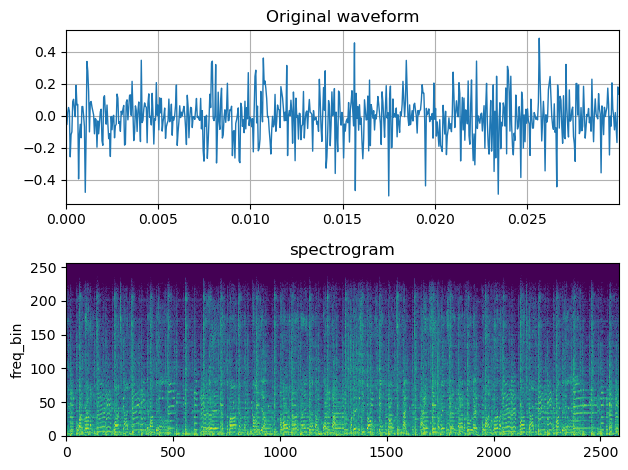

In [5]:
skip = 1000

fig, axs = plt.subplots(2, 1)
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, skip, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

In [6]:
print (spec.shape)

torch.Size([1, 257, 2586])


In [7]:
257//4, 2586//4

(64, 646)

# STEP-1: IMPLEMENT DATA READER CLASS

In [54]:
import glob
import time
import numpy as np
import torch as tc
import torchvision as tv

class AuReader(tc.utils.data.Dataset):
    
    ROOT_DIR = './data/genres/'
    N_FFT    = 512
    
    def __init__(self, transform):
        self.class_list = self.get_class()
        self.fp_list = self.load_fpdat()
        np.random.shuffle(self.fp_list)
        self.spectrogram = T.Spectrogram(n_fft=self.N_FFT)
        self.transform = transform
        return
    
    def get_class(self):
        fp_list = glob.glob(self.ROOT_DIR + '*')
        class_list = [item.split('/')[-1] for item in fp_list]
        return class_list
    
    def load_fp_from_class(self, class_name):
        #TODO: load list of files from given class
        ftemplate = self.ROOT_DIR + class_name + '/*'
        #print ('loading files from: ' + ftemplate)
        fp_list = glob.glob(ftemplate)
        return fp_list
    
    def load_fpdat(self):
        #TODO: load list of file path into fp_dict and fp_list for future usage
        result = []
        for class_name in self.class_list:
            fp_list = self.load_fp_from_class(class_name)
            for fp in fp_list:
                result.append([fp, class_name])
        return result
    
    def load_item(self, idx):
        #READ an item, convert to furier form before returning
        fp = self.fp_list[idx][0]
        SPEECH_WAVEFORM, SAMPLE_RATE = tca.load(fp, backend="sox")
        spec = self.spectrogram(SPEECH_WAVEFORM)
        spec = librosa.power_to_db(spec)
        spec = self.transform(spec[0])
        return spec
    
    #prepare write/read cache here is speed is slow (cpu bound preprocessing via spectrogram & power to db)
        
    def __len__(self):
        return len(self.fp_list)
    
    def __getitem__(self, idx):
        return self.load_item(idx), self.class_list.index(self.fp_list[idx][1]), self.fp_list[idx]

# STEP 2: TEST CORRECTNESS & VISUALIZE DATAREADER

In [55]:
testReader = AuReader(tv.transforms.Compose([]))
print ('Glancing at the dataset')
print ('List of classes: ', testReader.class_list)
print ('First 3 item in the dataset', testReader.fp_list[:3])

Glancing at the dataset
List of classes:  ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
First 3 item in the dataset [['./data/genres/hiphop/hiphop.00035.au', 'hiphop'], ['./data/genres/pop/pop.00017.au', 'pop'], ['./data/genres/metal/metal.00056.au', 'metal']]


7 ['./data/genres/pop/pop.00045.au', 'pop']


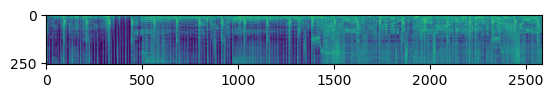

In [56]:
datitem, classid, classname = testReader[3]
#datitem = librosa.power_to_db(datitem)
#datitem = (datitem - datitem.min())/(datitem.max() - datitem.min())
plt.imshow(datitem)
print (classid, classname)

4 ['./data/genres/hiphop/hiphop.00063.au', 'hiphop']


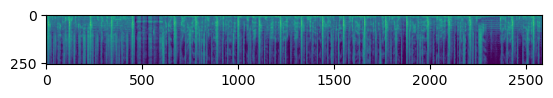

In [57]:
datitem, classid, classname = testReader[-1]
#datitem = librosa.power_to_db(datitem)
#datitem = (datitem - datitem.min())/(datitem.max() - datitem.min())
plt.imshow(datitem)
print (classid, classname)

# STEP3 - MODEL PROTOTYPE AND TRAINING

In [93]:
def modify_fc_layers(model):
        model.avgpool = tc.nn.AdaptiveAvgPool2d(1)
        model.fc = tc.nn.Linear(1 * 1 * 2048, 10)

### Save model at position
def save_tilemodel(net, epoch):
    tc.save(net.state_dict(), f'./models/model_epoch{epoch}')



#net = GenreClassifier(64, auReader.class_list).to(device)
net = tv.models.resnet50(pretrained=True)
modify_fc_layers(net)
net.to(device)

optim = tc.optim.Adam(net.parameters(), lr=3e-4)#tc.optim.Adam(net.parameters(), lr=3000)
criterion = tc.nn.CrossEntropyLoss()

loss_list = []
t_train_begin = time.time()
for epoch in range(0, N_EPOCHS): #test first, the sh, to see if it works
    for idx, item in enumerate(trainloader):
        btime = time.time()
        x, y, classname = item
        #print (y, classname)
        
        if tc.isnan(x).any() == True:
            raise
        
        x = x.type(tc.float32).to(device).repeat(1, 3, 1, 1)
        y = y.to(device)
        
        optim.zero_grad()
        output = net(x)
        loss = criterion(output, y)
        loss.backward() #CUDA out of memory here

        optim.step()
        
        #print (x[0][0][0][:6], y, output)
        loss_list.append(loss.detach().cpu().item())
        
        if epoch % 2 == 0 and idx == 0:
            print (f'''epoch: {epoch}, iter: {idx}, loss {loss.detach().cpu().item():.3f}''')
    if epoch % 20 == 0:
        print(f'Saving tile models at  epoch:{epoch}, idx:{idx}')
        save_tilemodel(net, epoch)
save_tilemodel(net, epoch)

/apps/mambaforge/envs/env_music/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/apps/mambaforge/envs/env_music/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 0, iter: 0, loss 2.342


KeyboardInterrupt: 

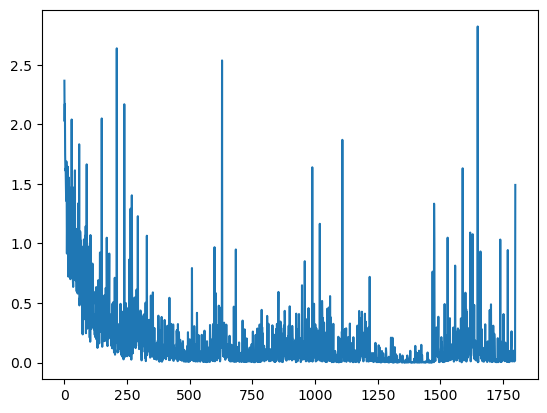

In [78]:
plt.plot(loss_list)


# STEP4 - EVALUATION

In [92]:
correct_pred = {classname: 0 for idx, classname in enumerate(auTrainReader.class_list)}
total_pred = {classname: 0 for idx, classname in enumerate(auTrainReader.class_list)}
class_dict = {idx:classname for idx, classname in enumerate(auTrainReader.class_list)}

# again no gradients needed
with tc.no_grad():
    for data in testloader:
        x, y, classname = data
        x = x.type(tc.float32).to(device).repeat(1, 3, 1, 1)
        y = y.to(device)
        outputs = net(x)
        _, predictions = tc.max(outputs, 1)
        # collect the correct predictions for each class
        for yitem, prediction in zip(y, predictions):
            if yitem == prediction:
                correct_pred[class_dict[yitem.cpu().item()]] += 1
            total_pred[class_dict[yitem.cpu().item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: blues is 71.4 %
Accuracy for class: classical is 95.5 %
Accuracy for class: country is 66.7 %
Accuracy for class: disco is 64.5 %
Accuracy for class: hiphop is 85.3 %
Accuracy for class: jazz  is 84.4 %
Accuracy for class: metal is 83.3 %
Accuracy for class: pop   is 80.8 %
Accuracy for class: reggae is 77.4 %
Accuracy for class: rock  is 30.6 %
